# Benchmarking classification time-complexity of SPORF on sklearn `bench_tree.py`

The purpose of the notebook is to benchmark time-complexity of Oblique Forest against sklearn Random Forest on two different `max_features` settings, where first setting is a default values `sqrt` and the other is the most basic setting that only uses `1` feature.

## Environment
- Python 3.8.10
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquetrees)

## Import packages

In [1]:
# from sklearn.tree import ObliqueDecisionTreeClassifier
from sklearn.ensemble import ObliqueRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
from datetime import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import gc
from datetime import datetime

# to store the results
scikit_classifier_results = []

train_switch = True #pkl save toggle
fig_switch = True #fig save toggle

algos = ['RF', 'OF']

mu_second = 0.0 + 10 ** 6  # number of microseconds in a second

In [2]:
today = str(datetime.now().date())
today

'2021-12-22'

## SPORF initialization

In [3]:
def init(kw):
    clf_rf = RandomForestClassifier(**kw)
    clf_of = ObliqueRandomForestClassifier(**kw)

    return clf_rf, clf_of

## Tree Benchmarking for classification adapted from sklearn `main` and modified for sporf benchmarking

In [4]:
def bench_scikit_tree_classifier(X, Y, kw, c=None):
    """Benchmark with scikit-learn decision tree classifier"""

    clf = init(kw=kw)[c]

    gc.collect()

    tstart = datetime.now()
    clf.fit(X, Y).predict(X)
    delta = datetime.now() - tstart

    scikit_classifier_results.append(delta.seconds + delta.microseconds / mu_second)

    return clf

### Parameterization is in reference to sklearn issue [#20819](https://github.com/scikit-learn/scikit-learn/issues/20819)

In [5]:
def run_test(n_samples=0, n=20, dim=10, step=5000, c=None, filename=None, train=True, switch=train_switch, kw=None):
    global scikit_classifier_results

    gc.collect() #without it, script crashes kernel after large enough sample size

    if not train:
        try:
            with open(filename, 'rb') as handle:
                scikit_classifier_results, clf = pickle.load(handle)
                print(f'[{filename}] loaded')
        except Exception as e:
            print(e)

        return scikit_classifier_results, clf
    
    scikit_classifier_results = []

    t_i = datetime.now()

    dim = dim
    n_classes = 10
    for i in range(n):
        n_samples += step
        X = np.random.randn(n_samples, dim)
        Y = np.random.randint(0, n_classes, (n_samples,))
        clf = bench_scikit_tree_classifier(X, Y, kw=kw, c=c)

    print(f'Total Runtime of {algos[c]} over {n} experiments: {datetime.now()-t_i}')
    
    if filename and switch:
        with open(filename, 'wb') as handle:
            pickle.dump([scikit_classifier_results, clf], handle, protocol=pickle.HIGHEST_PROTOCOL)

    return scikit_classifier_results, clf


### Get Average Depth of Trees

In [6]:
def get_avg_tree_depth(clf):
    for i, c in enumerate(clf):
        depth = [estimator.tree_.max_depth for estimator in c.estimators_]
        print(f'The average tree depth for {len(depth)} {algos[i]} trees is {np.mean(depth)}')

### Generate Figure

In [7]:
def generate_fig(dim=10, fig_switch=True):
    fig, ax = plt.subplots(1,1, figsize=(20,5))

    xx = np.arange(step, n*step+step, step)
    ax.plot(xx, rf_result, marker='o', label='Random Forest')
    ax.plot(xx, of_result, marker='o', label='Oblique Forest')

    ax.set_xlabel('Number of Samples', fontsize=18)
    ax.set_ylabel('Runtime for Training (secs)', fontsize=18)
    ax.legend(fontsize='20')
    ax.set_title(f'Runtime Performance with {dim} dimensions', fontsize=18)

    #save figure
    if fig_switch:
        fig.savefig(f'{today}_runtime_performance_dim={dim}_kw={kw["max_features"]}.jpg', bbox_inches='tight')


## Run sklearn tree benchmark

#### benchmarking setting

In [8]:
n = 5 # number of experiments with sample size increment of `step`
step = 1000000 #step size
dim = [10, 100, 1000] #dim of the simulation
saveDir = 'dat' #pickle save directory
np.random.RandomState(12345) #random state
train = True #training switch

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

#### benchmark for RF, oblique decision tree and oblique forest

Default case where `max_features` = 'sqrt'

##############################
Benchmarking with 10 dimension
##############################
Total Runtime of RF over 5 experiments: 0:01:02.968801
Total Runtime of OF over 5 experiments: 0:01:00.161874
The average tree depth for 100 RF trees is 53.67
The average tree depth for 100 OF trees is 56.76
##############################
Benchmarking with 100 dimension
##############################
Total Runtime of RF over 5 experiments: 0:03:11.296577
Total Runtime of OF over 5 experiments: 0:02:52.065588
The average tree depth for 100 RF trees is 54.84
The average tree depth for 100 OF trees is 54.62
##############################
Benchmarking with 1000 dimension
##############################
Total Runtime of RF over 5 experiments: 0:10:28.984668
Total Runtime of OF over 5 experiments: 0:08:00.530520
The average tree depth for 100 RF trees is 61.22
The average tree depth for 100 OF trees is 58.8


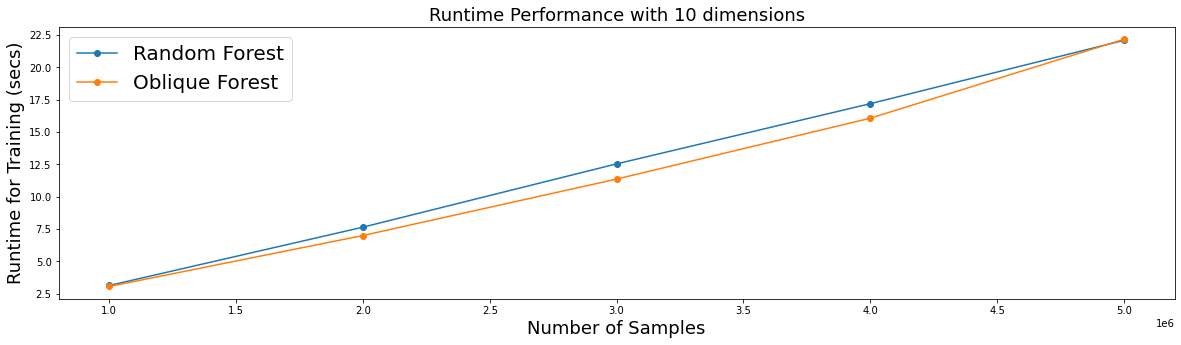

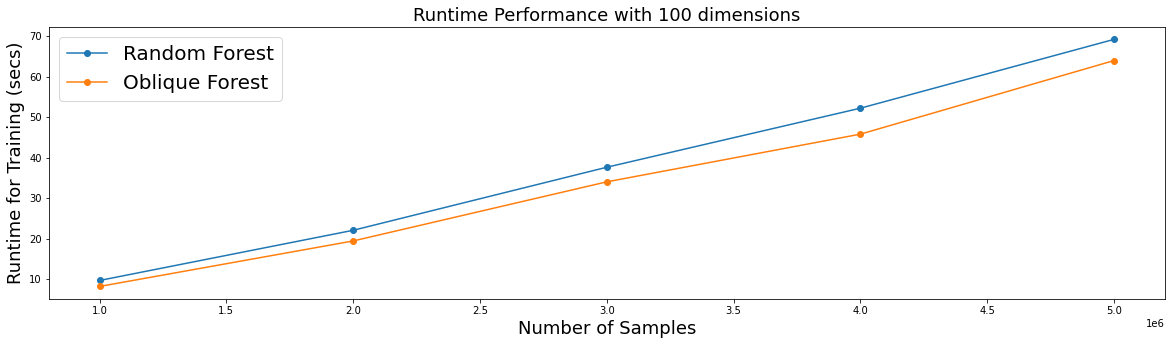

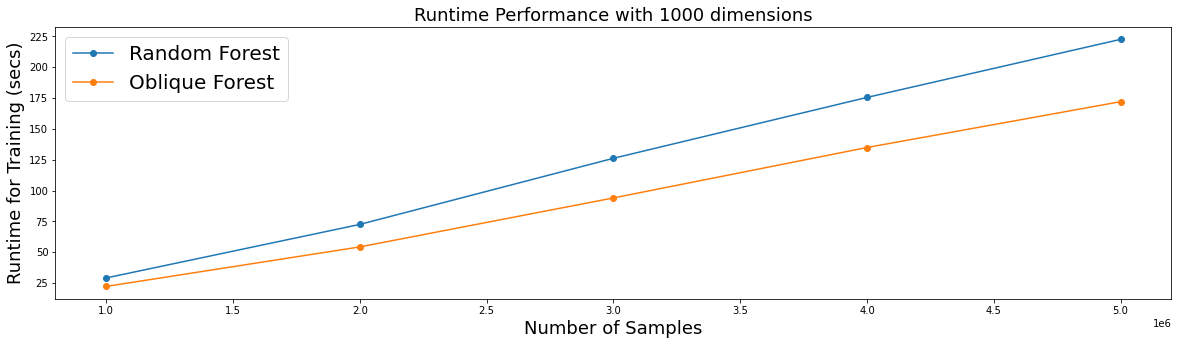

In [9]:
kw = {'max_features':'sqrt'}

for i in dim:
    print(f"{'#' * 30}\nBenchmarking with {i} dimension\n{'#' * 30}")
    tmp_clf = [0, 0]
    
    rf_result, tmp_clf[0] = run_test(n=n, dim=i, c=0, filename=f'{saveDir}/{today}_tree_benchmark_RF_dev_dim={i}_kw={kw["max_features"]}.pkl', train=train, kw=kw)
    of_result, tmp_clf[1] = run_test(n=n, dim=i, c=1, filename=f'{saveDir}/{today}_tree_benchmark_OF_dev_dim={i}_kw={kw["max_features"]}.pkl', train=train, kw=kw)
    
    get_avg_tree_depth(tmp_clf)

    generate_fig(dim=i, fig_switch=fig_switch)

Base case where `max_features` = 1

##############################
Benchmarking with 10 dimension
##############################
Total Runtime of RF over 5 experiments: 0:00:26.676841
Total Runtime of OF over 5 experiments: 0:00:31.321908
The average tree depth for 100 RF trees is 57.06
The average tree depth for 100 OF trees is 56.36
##############################
Benchmarking with 100 dimension
##############################
Total Runtime of RF over 5 experiments: 0:00:27.356164
Total Runtime of OF over 5 experiments: 0:00:32.522685
The average tree depth for 100 RF trees is 55.72
The average tree depth for 100 OF trees is 52.74
##############################
Benchmarking with 1000 dimension
##############################
Total Runtime of RF over 5 experiments: 0:00:31.808184
Total Runtime of OF over 5 experiments: 0:00:41.125427
The average tree depth for 100 RF trees is 54.51
The average tree depth for 100 OF trees is 52.52


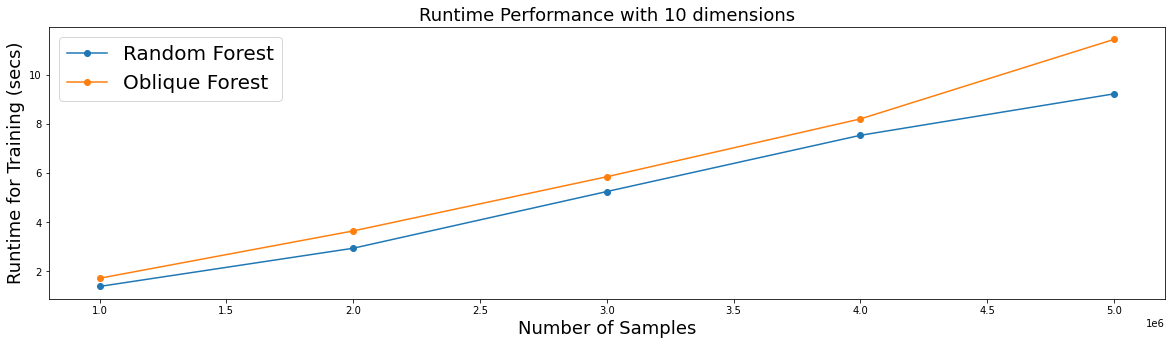

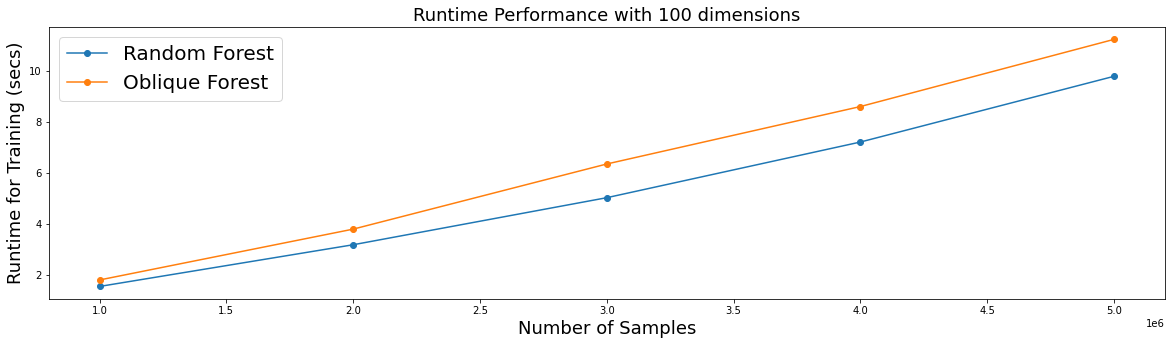

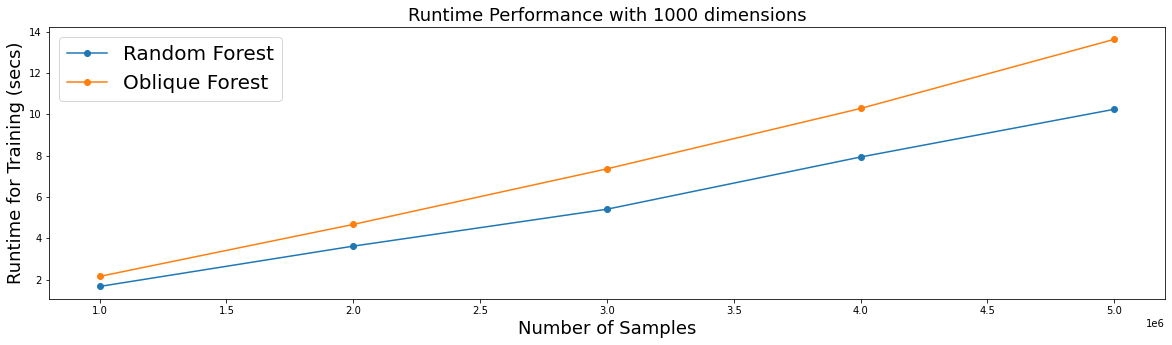

In [10]:
kw = {'max_features':1}

for i in dim:
    print(f"{'#' * 30}\nBenchmarking with {i} dimension\n{'#' * 30}")
    tmp_clf = [0, 0]
    
    rf_result, tmp_clf[0] = run_test(n=n, dim=i, c=0, filename=f'{saveDir}/{today}_tree_benchmark_RF_dev_dim={i}_kw={kw["max_features"]}.pkl', train=train, kw=kw)
    of_result, tmp_clf[1] = run_test(n=n, dim=i, c=1, filename=f'{saveDir}/{today}_tree_benchmark_OF_dev_dim={i}_kw={kw["max_features"]}.pkl', train=train, kw=kw)
    
    get_avg_tree_depth(tmp_clf)

    generate_fig(dim=i, fig_switch=fig_switch)